In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/zzz/

/content/drive/MyDrive/zzz


In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 26kB/s 
     |████████████████████████████████| 6.6MB 42.6MB/s 
ERROR: torchtext 0.9.0 has requirement torch==1.8.0, but you'll have torch 1.5.0+cu101 which is incompatible.
  Found existing installation: torch 1.8.0+cu101
    Uninstalling torch-1.8.0+cu101:
      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
     |████████████████████████████████| 276kB 11.3MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=10bff8daa6d9b8e21706f0344f095a71036d03efddf70a891e61ae511d2f52a4
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.

In [2]:
# install detectron2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2MB 818kB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210306-cp37-none-any.whl size=57728 sha256=b7da3e4991ab63fcfd5c20a4f906101033a395064ca505dc6f9890f6f6789167
  Stored in directory: /root/.cache/pip/wheels/26/3e/e3/65a5d883afb6617a61eba64e851b4d0e1f8653c9cff34dc8f3
  Created wheel for iopath: filename=iopath-0.1.4-cp37-none-any.whl size=15571 sha256=e4d6398a72c3de110f013b0e73bc17f8f8d112a6708bce7d0b77c7a75b7d011c
  Stored in directory: /root/.cache/pip/wheels/54/3b/fb/25b60ef5989e3f5fd76fdc575c922e6e59066ddbd1b44756a9
Successfully built fvcore iopath


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [4]:
!curl -L "https://app.roboflow.com/ds/J2x8J3DFMe?key=EH8EAyKOHE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1097      0 --:--:-- --:--:-- --:--:--  1097
100 2164k  100 2164k    0     0  1579k      0  0:00:01  0:00:01 --:--:-- 1579k
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_annotations.coco.json  
 extracting: test/frame189_jpg.rf.a5df241416d379667516d237bd5dac0c.jpg  
 extracting: test/frame191_jpg.rf.3a34a19135eaea56f043138732246f8a.jpg  
 extracting: test/frame319_jpg.rf.893678c3ee19c31943417eccbb058100.jpg  
 extracting: test/frame34_jpg.rf.0175c5ba9410c041370fb0329151f445.jpg  
 extracting: test/frame407_jpg.rf.1912a9745541073485009dcd7e9bda29.jpg  
 extracting: test/frame580_jpg.rf.475d7e7435575c4b6338653014128d09.jpg  
 extracting: test/frame713_jpg.rf.9965d78994559ee5afc94b03bbc408e5.jpg  
 extracting: test/frame719_jpg.rf.fc84347b87660761e

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [03/09 11:36:39 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/09 11:36:39 d2.data.datasets.coco]: Loaded 70 images in COCO format from /content/train/_annotations.coco.json


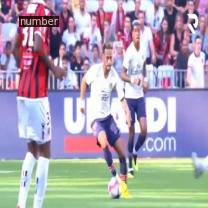

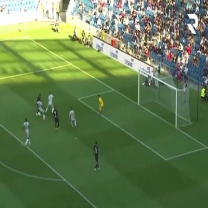

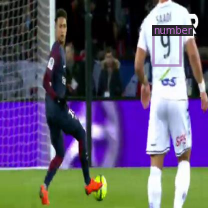

In [6]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [8]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [9]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.MAX_ITER = 1000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (500, 1000)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[03/09 11:37:03 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:31, 13.3MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.


[03/09 11:37:38 d2.engine.train_loop]: Starting training from iteration 0
[03/09 11:39:22 d2.utils.events]:  eta: 1:21:35  iter: 19  total_loss: 1.922  loss_cls: 1.619  loss_box_reg: 0.211  loss_rpn_cls: 0.120  loss_rpn_loc: 0.015  time: 5.1550  data_time: 0.0298  lr: 0.000039  max_mem: 7235M
[03/09 11:41:06 d2.utils.events]:  eta: 1:26:46  iter: 39  total_loss: 1.406  loss_cls: 0.935  loss_box_reg: 0.310  loss_rpn_cls: 0.086  loss_rpn_loc: 0.012  time: 5.2005  data_time: 0.0140  lr: 0.000079  max_mem: 7235M
[03/09 11:42:49 d2.utils.events]:  eta: 1:24:56  iter: 59  total_loss: 1.147  loss_cls: 0.580  loss_box_reg: 0.529  loss_rpn_cls: 0.051  loss_rpn_loc: 0.012  time: 5.1768  data_time: 0.0117  lr: 0.000119  max_mem: 7235M
[03/09 11:44:34 d2.utils.events]:  eta: 1:23:08  iter: 79  total_loss: 1.297  loss_cls: 0.437  loss_box_reg: 0.757  loss_rpn_cls: 0.039  loss_rpn_loc: 0.013  time: 5.1955  data_time: 0.0146  lr: 0.000159  max_mem: 7235M
[03/09 11:46:18 d2.utils.events]:  eta: 1:21:1

In [17]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [03/09 14:04:25 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[03/09 14:04:25 d2.data.datasets.coco]: Loaded 10 images in COCO format from /content/test/_annotations.coco.json
[03/09 14:04:25 d2.data.common]: Serializing 10 elements to byte tensors and concatenating them all ...
[03/09 14:04:25 d2.data.common]: Serialized dataset takes 0.00 MiB
[03/09 14:04:25 d2.evaluation.evaluator]: Start inference on 10 images
[03/09 14:04:31 d2.evaluation.evaluator]: Total inference time: 0:00:03.029552 (0.605910 s / img per device, on 1 devices)
[03/09 14:04:31 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.589385 s / img per device, on 1 devices)
[03/09 14:04:31 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/09 14:04:31 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[03/09 14:04:31 d2.evaluation.coco_evaluation]: Evaluating predic

OrderedDict([('bbox',
              {'AP': 31.31188118811881,
               'AP-number': 31.31188118811881,
               'AP50': 80.19801980198021,
               'AP75': 30.69306930693069,
               'APl': nan,
               'APm': 38.98514851485149,
               'APs': 0.0})])

In [15]:
%ls ./output/

coco_instances_results.json                       last_checkpoint
events.out.tfevents.1615289825.24e4452274d9.60.0  metrics.json
instances_predictions.pth                         model_final.pth


In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

Instances(num_instances=1, image_height=416, image_width=416, fields=[pred_boxes: Boxes(tensor([[139.2932, 199.1898, 197.6258, 311.1433]], device='cuda:0')), scores: tensor([0.9978], device='cuda:0'), pred_classes: tensor([1], device='cuda:0')])


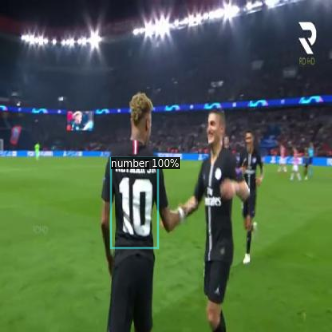

In [118]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/train/frame516_jpg.rf.2c84c81d3e8c32db88be4c765aab3c00.jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  print(outputs["instances"])
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
  


10


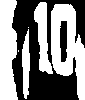

In [119]:
import re
def replace_chars(text):
    list_of_numbers = re.findall(r'\d+', text)
    result_number = ''.join(list_of_numbers)
    return result_number

image = cv2.imread('/content/train/frame516_jpg.rf.2c84c81d3e8c32db88be4c765aab3c00.jpg', 0)
thresh = 255 - cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

x,y,w,h = 115, 220, 85, 100
ROI = thresh[y:y+h,x:x+w]
data = pytesseract.image_to_string(ROI,lang='eng',config='--psm 6')
print(data)

cv2_imshow(ROI)


In [ ]:
while True:pass

In [27]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 0s (20.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5

In [28]:
import pytesseract
import shutil
import os
import random
try:
 from PIL import Image
except ImportError:
 import Image

In [32]:
image_path_in_colab='/content/blah.jpg'
extractedInformation = pytesseract.image_to_string(Image.open(image_path_in_colab))
print(extractedInformation)